In [1]:
# load in melanoma/lung, map cancer stage to ordinal scale, identify correlating RNA expressions

# MIC, Pearson, Spearman, Distance correlation, monotonic_alignment, pca/fa

import omic_helpers
import random
import numpy as np
import scipy as sc
import pandas as pd
import vaex as vx
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import LocallyLinearEmbedding as LLE, Isomap
from sklearn.decomposition import PCA

import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
from tqdm import tqdm
plotly.offline.init_notebook_mode(connected=True)
cm = sns.light_palette("green", as_cmap=True)

import sys, os, gc
from collections import defaultdict

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [3]:
def plot3d(xlist, title="", names=[]):
    fig = go.Figure(layout={'title': title})
    for idx, x in enumerate(xlist):
        name = names[idx]
        fig.add_trace(go.Scatter3d(
            x=x[:,0],
            y=x[:,1],
            z=x[:,2],
            mode='markers',
            marker={
                'size': 9,
                'opacity': 0.25,
            },
            name=name
        )
        )
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    plotly.offline.iplot(fig)

In [4]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression/hackathon_2')

In [5]:
ctype='Lung'
include_alt_corrs = False

In [6]:
ds = {}
ds['RNAex'] = pd.read_csv(ctype+'/'+ctype+'_GeneExpression.txt', sep='\t')

In [7]:
methylation = pd.read_csv(ctype+'/'+ctype+'_Methylation.txt', sep="\t")
methylation_meta = pd.read_csv(ctype+'/HumanMethylation450_meta.csv', sep="\t")

In [8]:
CNV= pd.read_csv(ctype+'/'+ctype+'_CNV.txt', sep='\t')
mutation = pd.read_csv(ctype+'/'+ctype+'_Mutation.txt', sep='\t')

miRNA = pd.read_csv(ctype+'/'+ctype+'_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv(ctype+'/'+ctype+"_Proteome.txt", sep="\t")
#proteome = proteome.set_index('sample').transpose()
proteome_transposed = proteome.set_index('sample').T

meta = pd.read_csv(ctype+'/'+ctype+'_Phenotype_Metadata.txt', sep='\t')
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [9]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 1, 'stage ia': 1.5, 'stage ib': 1.75,
             'stage ii': 2, 'stage iia': 2.5, 'stage iib': 2.75,
             'stage iii': 3,'stage iiia': 3.5, 'stage iiib': 3.75,
             'stage iv' : 4}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)

T_map = {'TX': np.nan, 'T1':1, 'T2': 4, 'T3': 6, 'T4': 8, 'T1a': 2, 'T1b': 3, 'T2a': 3.5, 'T2b': 5}
N_map = {'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'NX': np.nan}
M_map = {'M0': 0, 'M1': 1, 'M1a': 2, 'M1b': 3, 'M1c': 4, 'MX': np.nan}

meta['Tstage'] = meta['T-stage'].map(T_map)
meta['Nstage'] = meta['N-stage'].map(N_map)
meta['Mstage'] = meta['M-stage'].map(M_map)

########
if ctype=='Lung':
    smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
                 'Current Reformed Smoker for > 15 yrs': 'reformed',
                 'Current Reformed Smoker, Duration Not Specified': 'reformed',
                 'Current Smoker': 'current',
                 'Lifelong Non-Smoker': 'non-smoker'}
    meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Response To Therapy'].map(response_map)

meta.dropna(subset=['Overall Survival Status'], inplace=True)
meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))
meta.reset_index(inplace=True)
meta['SampleID'] = meta.SampleID.apply(lambda x: x.replace("_", "-"))
meta.set_index('SampleID', inplace=True)

In [10]:
meta = meta[meta['Sample Type']=='Primary Tumor']

In [11]:
ds['RNAex'].Gene = ds['RNAex'].Gene.str.upper()
ds['RNAex'].sort_values(by='Gene', inplace=True)
ds['RNAex'].Start = ds['RNAex'].Start.astype(str)
ds['RNAex'].Stop = ds['RNAex'].Stop.astype(str)
ds['RNAex'].Strand = ds['RNAex'].Strand.astype(str)
ds['RNAex']['rnaID'] = ds['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x:
                                                                                     "_".join(x), axis=1)
rnamap = ds['RNAex'][['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
rnamap.drop_duplicates(subset=['Gene', 'Chr', 'Start', 'Stop', 'Strand'])
ds['RNAex'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
ds['RNAex'] = ds['RNAex'].set_index('rnaID').transpose()
gc.collect()
rnamap.set_index('rnaID', inplace=True)

# Clustering

## CNV

In [12]:
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Strand = CNV.Strand.astype(str)
CNV['rnaID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x:
                                                                            "_".join(x), axis=1)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV.set_index('rnaID', inplace=True)
CNV_transpose = CNV.T

In [13]:
embedder_lle = LLE(n_components=2)
embedder_umap = UMAP(n_components=2)
embedder_iso = Isomap(n_components=2)

In [14]:
embedder_lle.fit(CNV_transpose)
embed = embedder_lle.transform(CNV_transpose)
embed_lle_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_lle_cnv = embed_lle_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [15]:
embedder_umap.fit(CNV_transpose)
embed = embedder_umap.transform(CNV_transpose)
embed_umap_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_umap_cnv = embed_umap_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                   'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [151]:
embedder_iso.fit(CNV_transpose)
embed = embedder_iso.transform(CNV_transpose)
embed_iso_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_iso_cnv = embed_iso_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                   'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

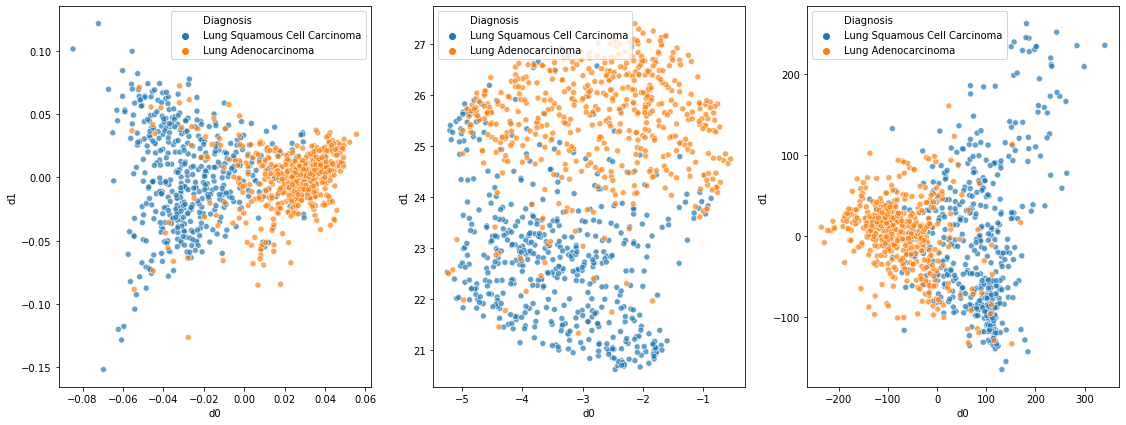

In [152]:
cat = 'Diagnosis'

fig, ax = plt.subplots(ncols=3, figsize=(19,7))
sns.scatterplot(data=embed_lle_cnv, x='d0', y='d1', alpha=0.7, ax=ax[0], hue=cat) #, palette='Spectral')
sns.scatterplot(data=embed_umap_cnv, x='d0', y='d1', alpha=0.7, ax=ax[1], hue=cat) #, palette='Spectral')
sns.scatterplot(data=embed_iso_cnv, x='d0', y='d1', alpha=0.7, ax=ax[2], hue=cat) #, palette='Spectral')

## Proteome

In [18]:
from sklearn.decomposition import NMF
from sklearn.impute import IterativeImputer, KNNImputer

impute_choice = 'iterative'
transformer, inv_transformer = np.exp, np.log

In [19]:
proteome_transposed =proteome.set_index('sample').T
if transformer is not None:
    proteome_transposed = transformer(proteome_transposed)

    
def impute_wrapper(X, impute_method='iterative'):
    if impute_method == 'iterative':    
        imputer = IterativeImputer(max_iter=50, verbose=2)
        dft = imputer.fit_transform(X)
        dft = pd.DataFrame(data=dft, index=X.index, columns=X.columns.tolist())
    elif impute_method == 'nmf':    
        # get rid of NaN's with NMF
        # https://codereview.stackexchange.com/questions/96725/imputing-values-with-non-negative-matrix-factorization
        mf_nmf= NMF(verbose=2)
        dft = X.copy()
        msk = np.argwhere(np.isnan(dft.values))
        dft.fillna(0, inplace=True)
        mf_nmf.fit(dft)
        while mf_nmf.reconstruction_err_**2 > 10:
            W = mf_nmf.fit_transform(dft.values)
            dft.values[~msk] = W.dot(mf_nmf.components_)[~msk]
            print(mf_nmf.reconstruction_err_)
    elif impute_method == 'knn':
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        dft = imputer.fit_transform(X)
        dft = pd.DataFrame(data=dft, index=X.index, columns=X.columns.tolist())        
    return dft

In [20]:
dft = impute_wrapper(proteome_transposed, impute_method=impute_choice)

[IterativeImputer] Completing matrix with shape (693, 276)
[IterativeImputer] Ending imputation round 1/50, elapsed time 22.07
[IterativeImputer] Change: 1739.5686492473747, scaled tolerance: 2.7240476846655115 
[IterativeImputer] Ending imputation round 2/50, elapsed time 44.21
[IterativeImputer] Change: 266.87984860480594, scaled tolerance: 2.7240476846655115 
[IterativeImputer] Ending imputation round 3/50, elapsed time 64.68
[IterativeImputer] Change: 215.57215266834066, scaled tolerance: 2.7240476846655115 
[IterativeImputer] Ending imputation round 4/50, elapsed time 92.15
[IterativeImputer] Change: 64.52323571491735, scaled tolerance: 2.7240476846655115 
[IterativeImputer] Ending imputation round 5/50, elapsed time 151.84
[IterativeImputer] Change: 18.950419543884458, scaled tolerance: 2.7240476846655115 
[IterativeImputer] Ending imputation round 6/50, elapsed time 208.64
[IterativeImputer] Change: 15.825830886470007, scaled tolerance: 2.7240476846655115 
[IterativeImputer] End

In [21]:
# patient clustering
pat_corr = dft.T.corr(method='spearman')
pat_cos = -(dft.T.corr(method=sc.spatial.distance.cosine)-1)

INFO:MainThread:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


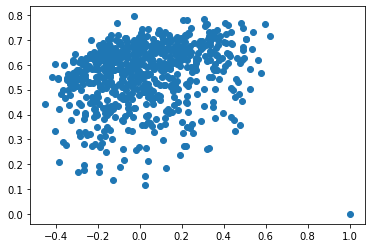

In [22]:
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [23]:
embedder_lle = LLE(n_components=2)

embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_lle_sim_proteome = embed_lle_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(dft)
embed = embedder_lle.transform(dft)
embed_lle_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_lle_proteome = embed_lle_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_iso = Isomap(n_components=2)

embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_sim_proteome = embed_iso_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(dft)
embed = embedder_iso.transform(dft)
embed_iso_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_proteome = embed_iso_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_umap = UMAP(n_components=2)

embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_sim_proteome = embed_umap_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(dft)
embed = embedder_umap.transform(dft)
embed_umap_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_proteome = embed_umap_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

Text(0.5, 1.0, 'UMAP on similarities')

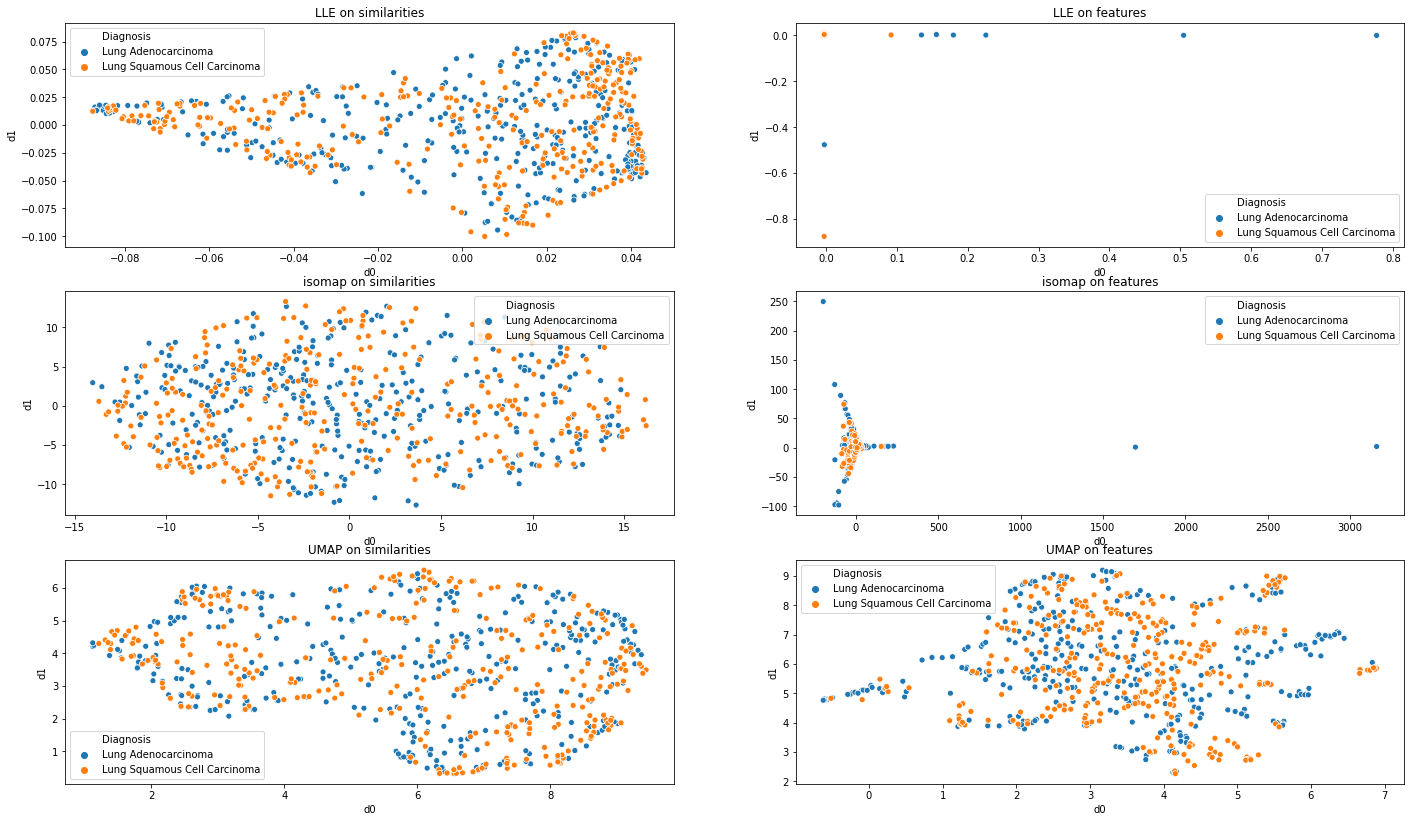

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_proteome, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_proteome, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_proteome, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')


In [25]:
from sklearn.neighbors import NearestNeighbors

In [27]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors.fit(embed_lle_sim_proteome[['d0','d1']])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius=1.0)

In [29]:
# algo: take N nearestneighbors and use weighted average to replace NaN's
def nn_impute(X, msk, nnlist, nndist):
    for i,j in tqdm(msk):
        weights = 1/nndist[i]

        nbrs = list(nnlist[i])
        v = X.iloc[nbrs, j]
        nnanidx = np.argwhere(~np.array(np.isnan(v)))[:,0]    

        weights /=sum(weights[nnanidx])
        X.iloc[i, j] = np.sum(weights[nnanidx]*v[nnanidx])
    return X
msk = np.argwhere(np.isnan(proteome_transposed.values))
proteome_transposed = nn_impute(proteome_transposed, msk,neighbors.kneighbors()[1], neighbors.kneighbors()[0])

100%|██████████| 31554/31554 [00:34<00:00, 923.78it/s]


In [30]:
if inv_transformer is not None:
    proteome_transposed = inv_transformer(proteome_transposed)

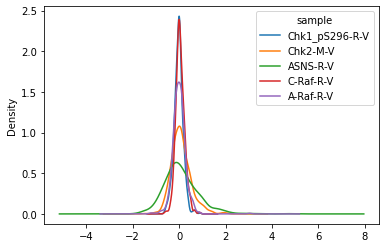

In [34]:
proteome_transposed.iloc[:, random.sample(range(100), 5)].plot.kde()

## miRNA

In [35]:
miRNA_imputed = impute_wrapper(miRNA, impute_method='knn')

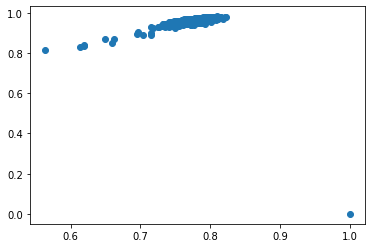

In [36]:
# patient clustering
pat_corr = miRNA_imputed.T.corr(method='spearman')
pat_cos = -(miRNA_imputed.T.corr(method=sc.spatial.distance.cosine)-1)
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [39]:
embedder_lle = LLE(n_components=2)
embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_sim_mirna = embed_lle_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(miRNA_imputed)
embed = embedder_lle.transform(miRNA_imputed)
embed_lle_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_mirna = embed_lle_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_sim_mirna = embed_iso_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(miRNA_imputed)
embed = embedder_iso.transform(miRNA_imputed)
embed_iso_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_mirna = embed_iso_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_umap = UMAP(n_components=2)
embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_umap_sim_mirna = embed_umap_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(miRNA_imputed)
embed = embedder_umap.transform(miRNA_imputed)
embed_umap_mirna = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_mirna = embed_umap_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

Text(0.5, 1.0, 'UMAP on similarities')

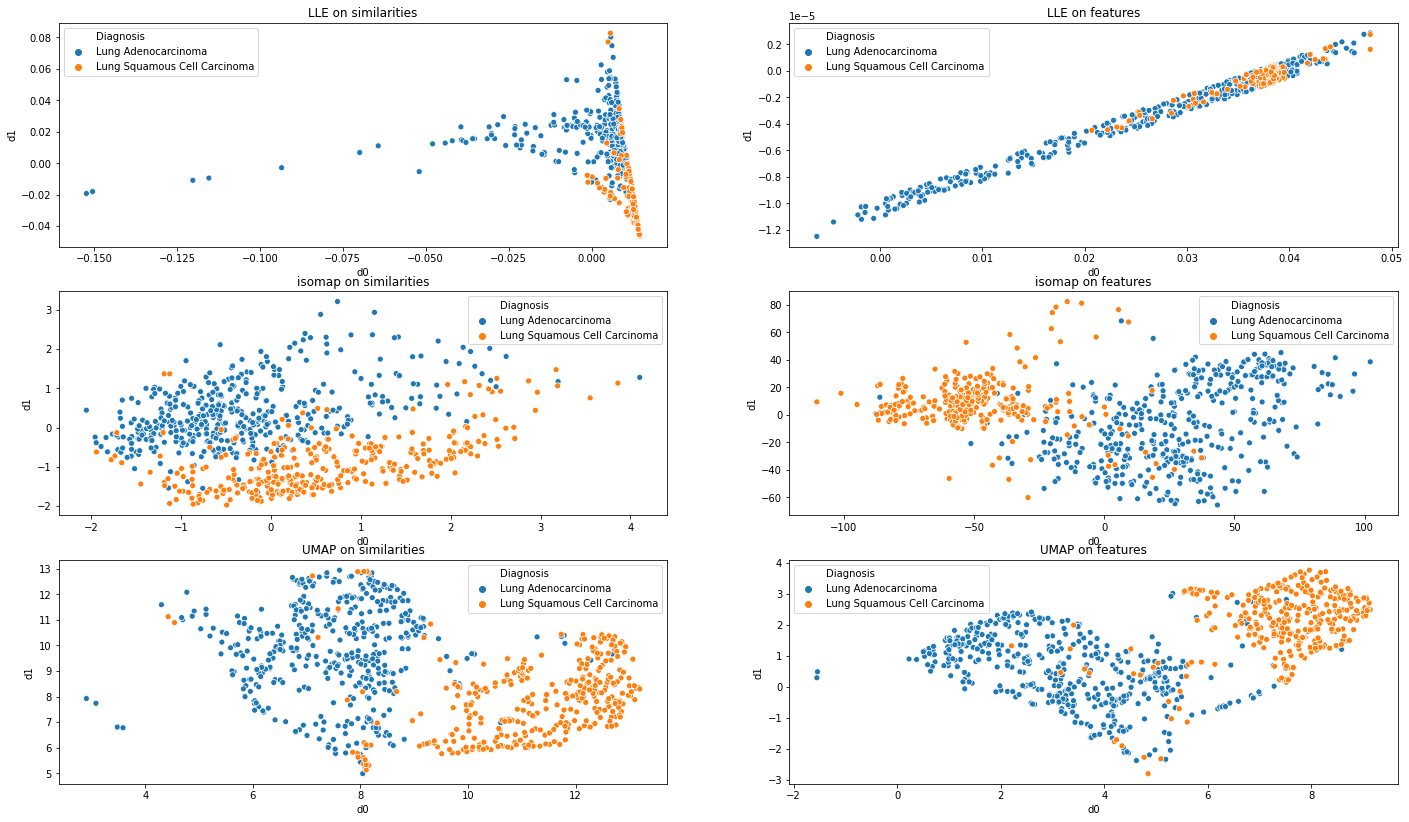

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_mirna, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_mirna, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_mirna, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')


In [41]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors.fit(embed_umap_sim_mirna[['d0','d1']])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius=1.0)

In [42]:
# algo: take N nearestneighbors and use weighted average to replace NaN's
def nn_impute(X, msk, nnlist, nndist):
    for i,j in tqdm(msk):
        weights = 1/nndist[i]

        nbrs = list(nnlist[i])
        v = X.iloc[nbrs, j]
        nnanidx = np.argwhere(~np.array(np.isnan(v)))[:,0]    

        weights /=sum(weights[nnanidx])
        X.iloc[i, j] = np.sum(weights[nnanidx]*v[nnanidx])
    return X

msk = msk = np.argwhere(np.isnan(miRNA.values))
miRNA_imputed = nn_impute(miRNA_imputed, msk,neighbors.kneighbors()[1], neighbors.kneighbors()[0])

100%|██████████| 52075/52075 [00:55<00:00, 937.55it/s]


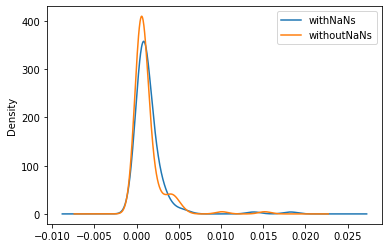

In [43]:
nancols = np.unique(msk[:,1])
#rrange = nancols[random.sample(range(len(nancols)), 5)]
miRNA.iloc[:, nancols].mean().plot.kde(label='withNaNs')
miRNA_imputed.iloc[:, nancols].mean().plot.kde(label='withoutNaNs')
plt.legend()

## RNA expression

In [47]:
RNAex = ds['RNAex']
del ds
gc.collect()
RNAex_T = RNAex.T

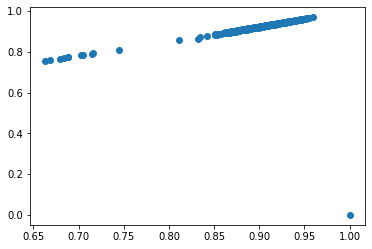

In [48]:
# patient clustering
pat_corr = RNAex_T.corr(method='pearson')
pat_cos = -(RNAex_T.corr(method=sc.spatial.distance.cosine)-1)
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [50]:
embedder_lle = LLE(n_components=2)
embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_sim_rnaex = embed_lle_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(RNAex)
embed = embedder_lle.transform(RNAex)
embed_lle_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_rnaex = embed_lle_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_sim_rnaex = embed_iso_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(RNAex)
embed = embedder_iso.transform(RNAex)
embed_iso_rnaex  = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_rnaex  = embed_iso_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])



embedder_umap = UMAP(n_components=2)
embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_umap_sim_rnaex = embed_umap_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(RNAex)
embed = embedder_umap.transform(RNAex)
embed_umap_rnaex = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_rnaex = embed_umap_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

Text(0.5, 1.0, 'UMAP on similarities')

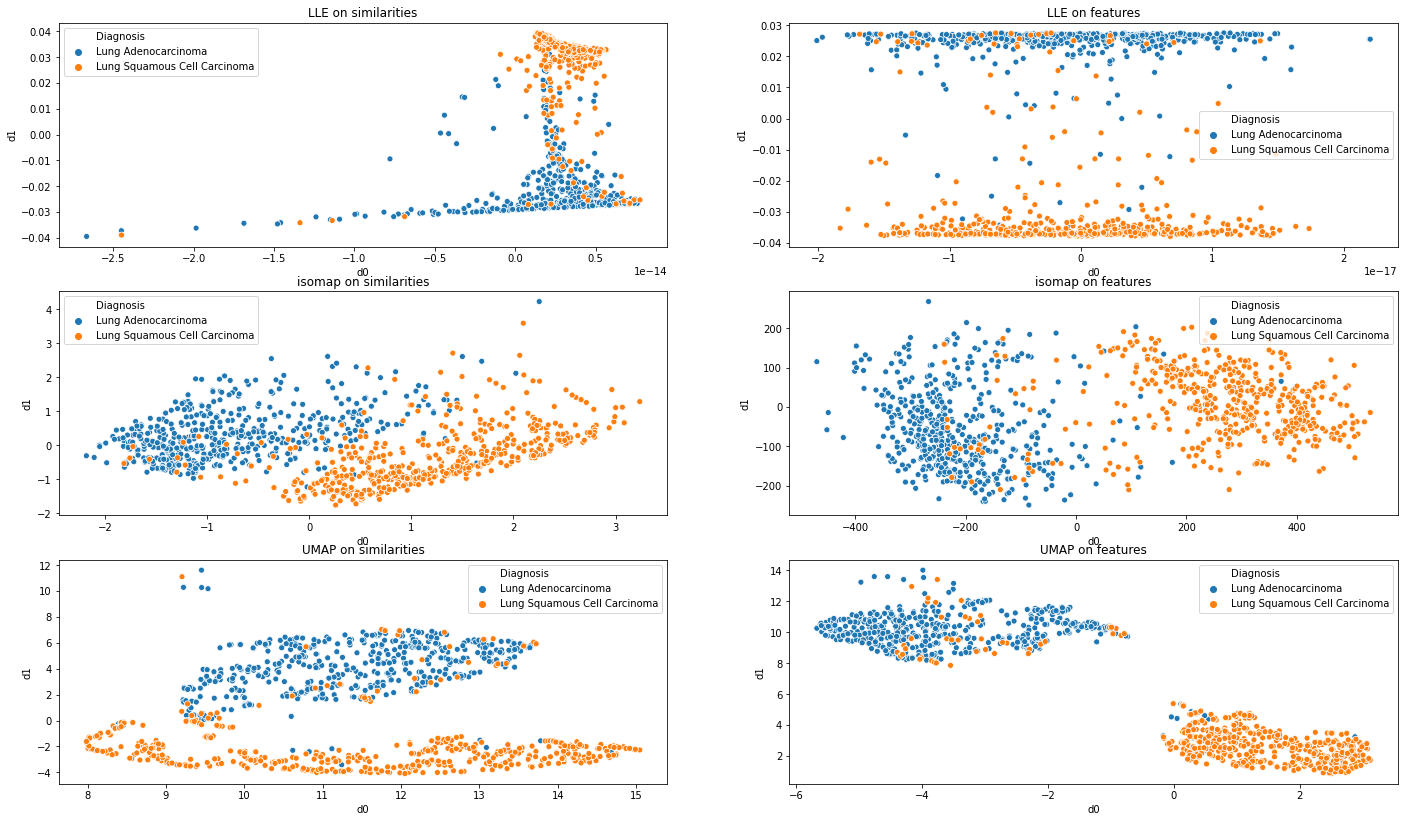

In [53]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_rnaex, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_rnaex, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_rnaex, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')

## Mutation

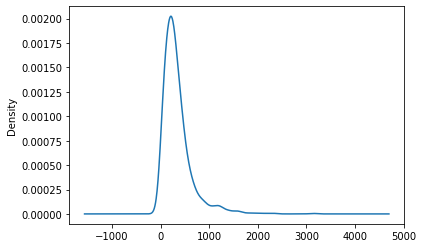

In [67]:
mutation.groupby('Sample_ID').Gene.nunique().plot.kde()

In [68]:
mutation.columns

Index(['Sample_ID', 'Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt', 'Amino_Acid_Change', 'Effect'], dtype='object')

In [69]:
# per Sample ID, per gene: # number of mutations
# TODO: EffectMain -> needs to be collapsed into a few main mutation types
# TODO: GeneOnto -> Gene ontology needs to be added, Gene mutations are too dispersed
# if we have the molecular function, biological process and cellular component for each gene 
# we can create informative graphs
mutation.set_index('Sample_ID', inplace=True)
mutation_merged = mutation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [70]:
mutation = mutation.loc[mutation.Gene!='Unknown']
mutation = mutation.loc[mutation.Gene!='Y_RNA']
mutation = mutation.loc[mutation.Gene!='Metazoa_SRP']

In [71]:
tmp = pd.DataFrame(mutation_merged[['Diagnosis', 'Gender', 'Gene']].groupby(['Diagnosis', 'Gender', 'Gene']).size())
tmp.columns = ['mutation_count']
tmp.reset_index(inplace=True)

In [72]:
tmp_LA_male = tmp.loc[(tmp.Diagnosis=='Lung Adenocarcinoma') & (tmp.Gender==0.0)]
tmp_LA_female = tmp.loc[(tmp.Diagnosis=='Lung Adenocarcinoma') & (tmp.Gender==1.0)]
tmp_LSCC_male = tmp.loc[(tmp.Diagnosis=='Lung Squamous Cell Carcinoma') & (tmp.Gender==0.0)]
tmp_LSCC_female = tmp.loc[(tmp.Diagnosis=='Lung Squamous Cell Carcinoma') & (tmp.Gender==1.0)]

In [73]:
tmp_LSCC_male.sort_values(by='mutation_count', ascending=False)[:100]

,Diagnosis,Gender,Gene,mutation_count
50372,Lung Squamous Cell Carcinoma,0.0,TTN,908
43347,Lung Squamous Cell Carcinoma,0.0,MUC16,355
49935,Lung Squamous Cell Carcinoma,0.0,TP53,329
37216,Lung Squamous Cell Carcinoma,0.0,CSMD3,286
47243,Lung Squamous Cell Carcinoma,0.0,RYR2,231
49025,Lung Squamous Cell Carcinoma,0.0,SYNE1,228
42237,Lung Squamous Cell Carcinoma,0.0,LRP1B,201
50671,Lung Squamous Cell Carcinoma,0.0,USH2A,201
51273,Lung Squamous Cell Carcinoma,0.0,ZFHX4,189
38724,Lung Squamous Cell Carcinoma,0.0,FAM135B,145


In [74]:
tmp_LSCC_female.sort_values(by='mutation_count', ascending=False)[:100]

,Diagnosis,Gender,Gene,mutation_count
64706,Lung Squamous Cell Carcinoma,1.0,TTN,298
59311,Lung Squamous Cell Carcinoma,1.0,MUC16,99
64380,Lung Squamous Cell Carcinoma,1.0,TP53,95
62340,Lung Squamous Cell Carcinoma,1.0,RYR2,86
54617,Lung Squamous Cell Carcinoma,1.0,CSMD3,83
58500,Lung Squamous Cell Carcinoma,1.0,LRP1B,74
64921,Lung Squamous Cell Carcinoma,1.0,USH2A,67
65388,Lung Squamous Cell Carcinoma,1.0,ZFHX4,66
63721,Lung Squamous Cell Carcinoma,1.0,SYNE1,62
65220,Lung Squamous Cell Carcinoma,1.0,XIRP2,55


We have to be aware that each gene can consist of more or less base pairs. The most mutated gene is TTN or Titin, which is also the **largest** gene in terms of number of exons and the gene containing the largest single exon (of 17,106 bp).  (less importantly but interesting nonetheless, the TTN proteine encoded by the gene is also the largest known protein).

A simple mitigation of this confounder is the inclusion of the sequence length per gene.

In [75]:
rnamap['genome_length'] = rnamap['Stop'].astype(int)- rnamap['Start'].astype(int) 

In [76]:
mutation['mutation_length'] = mutation['Stop'] - mutation['Start']

In [77]:
mutlength = mutation[['Gene', 'Start']].groupby('Gene').agg('max')-mutation[['Gene', 'Start']].groupby('Gene').agg('min')
mutlength.columns=['total_mutation_length']
mutation = mutation.merge(mutlength, left_on='Gene', right_index=True, how='left')
genelength= pd.DataFrame(rnamap.groupby('Gene').genome_length.sum())
mutation = mutation.merge(genelength, left_on='Gene', right_index=True, how='left')

In [91]:
mutation

,Gene,Chr,Start,Stop,Ref,Alt,Amino_Acid_Change,Effect,mutation_length,total_mutation_length,genome_length
Sample_ID,,,,,,,,,,,
TCGA-49-4490-01,UBR4,chr1,19155452,19155452,C,T,p.E2097K,missense_variant,0,124026,135770.0
TCGA-49-4490-01,PLA2G2D,chr1,20115562,20115562,G,A,p.C79C,synonymous_variant,0,1480,7627.0
TCGA-49-4490-01,MTF1,chr1,37822366,37822366,A,G,p.S508P,missense_variant,0,42393,50053.0
TCGA-49-4490-01,CLCA2,chr1,86443922,86443922,G,A,p.D542N,missense_variant,0,31374,32472.0
TCGA-49-4490-01,WNT2B,chr1,112525957,112525957,G,C,NaN,downstream_gene_variant,0,34929,63624.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-8353-01,MAGEB1,chrX,30250548,30250548,C,A,p.R19R,synonymous_variant,0,1168,8308.0
TCGA-85-8353-01,CFAP47,chrX,35975819,35975819,T,A,p.V873V,synonymous_variant,0,225188,NaN
TCGA-85-8353-01,ALAS2,chrX,55021208,55021208,G,T,p.T161N,missense_variant,0,16849,22009.0


In [90]:
mutation.index[(mutation.total_mutation_length/mutation.genome_length)>100]

Index(['TCGA-44-A47A-01', 'TCGA-53-7624-01', 'TCGA-17-Z011-01', 'TCGA-49-6743-01', 'TCGA-62-A471-01', 'TCGA-55-7907-01', 'TCGA-50-5049-01', 'TCGA-75-6214-01', 'TCGA-75-6214-01', 'TCGA-MN-A4N4-01', 'TCGA-MP-A4TK-01', 'TCGA-95-A4VN-01', 'TCGA-50-5930-01', 'TCGA-L9-A444-01', 'TCGA-55-8090-01', 'TCGA-44-A47G-01', 'TCGA-05-4398-01', 'TCGA-50-5044-01', 'TCGA-17-Z062-01', 'TCGA-55-A490-01', 'TCGA-55-8203-01', 'TCGA-55-8089-01', 'TCGA-90-7964-01', 'TCGA-63-A5M9-01', 'TCGA-63-A5M9-01', 'TCGA-37-3792-01', 'TCGA-43-6770-01', 'TCGA-43-6770-01', 'TCGA-58-A46M-01', 'TCGA-77-7465-01', 'TCGA-58-8391-01', 'TCGA-63-A5MM-01', 'TCGA-43-2581-01', 'TCGA-56-7731-01', 'TCGA-22-4594-01', 'TCGA-51-6867-01', 'TCGA-60-2726-01', 'TCGA-85-8277-01', 'TCGA-34-2609-01', 'TCGA-56-7221-01', 'TCGA-85-8350-01'], dtype='object', name='Sample_ID')

## Methylation

In [57]:
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'],inplace=True, axis=1)
methylation.set_index('probeID', inplace=True)
keep_cols = methylation.index[methylation.isna().sum(axis=1)<400]
methylation = methylation.loc[keep_cols]
methylation_T = methylation.T

In [58]:
# impute
methylation_T = impute_wrapper(methylation_T, impute_method='knn')

In [59]:
decomp_pca = PCA(n_components=100)

In [60]:
decomp_pca.fit(methylation_T)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

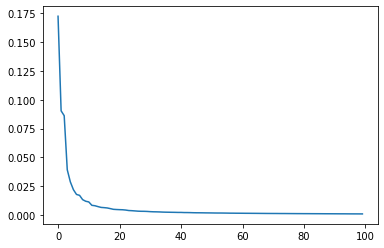

In [61]:
plt.plot(decomp_pca.explained_variance_ratio_)

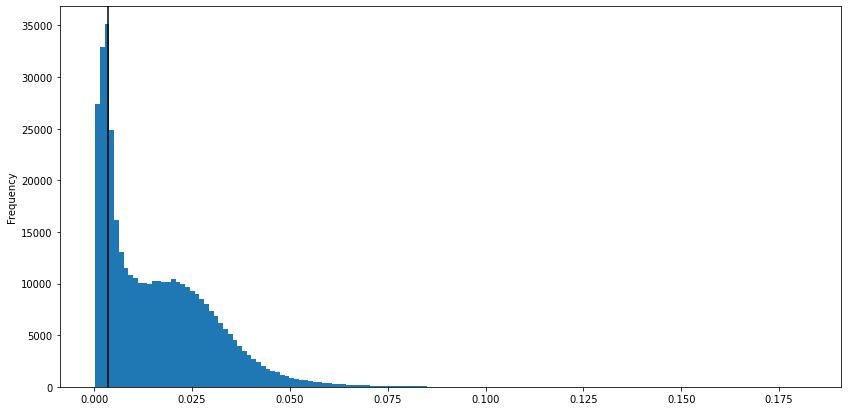

In [62]:
methyl_var = (methylation_T.var()/(methylation_T.max()-methylation_T.min()))
methyl_var.plot.hist(bins=150, figsize=(14,7))
plt.axvline(0.0035, color='black')

In [63]:
keep_cols = methylation_T.columns[methyl_var>0.0035].tolist()
methylation_T = methylation_T.loc[:,keep_cols]

In [64]:
embedder_lle = LLE(n_components=2)
embedder_lle.fit(methylation_T)
embed = embedder_lle.transform(methylation_T)
embed_lle_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_lle_methylation = embed_lle_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(methylation_T)
embed = embedder_iso.transform(methylation_T)
embed_iso_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_iso_methylation = embed_iso_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap = UMAP(n_components=2)
embedder_umap.fit(methylation_T)
embed = embedder_umap.transform(methylation_T)
embed_umap_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_umap_methylation = embed_umap_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

Text(0.5, 1.0, 'UMAP on features')

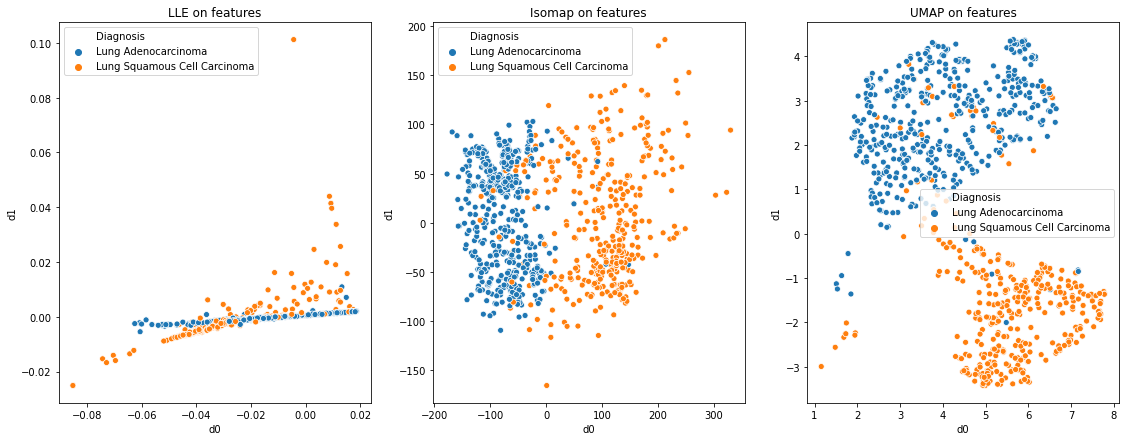

In [66]:
fig, ax = plt.subplots(ncols=3, figsize=(19,7))

cat = 'Diagnosis' # Gender
sns.scatterplot(data=embed_lle_methylation, x='d0', y='d1', hue=cat, ax=ax[0])
sns.scatterplot(data=embed_iso_methylation, x='d0', y='d1', hue=cat, ax=ax[1])
sns.scatterplot(data=embed_umap_methylation, x='d0', y='d1', hue=cat, ax=ax[2])

ax[0].set_title('LLE on features')
ax[1].set_title('Isomap on features')
ax[2].set_title('UMAP on features')


# Multi-omic clustering

https://github.com/rmarkello/snfpy

In [123]:
dimensions = {'rnaex': 5, 'methylation': 10, 'cnv': 3, 'proteomic': 3, 'mirna': 3}

momic = embed_umap_rnaex.join(embed_umap_methylation[['d0', 'd1']], rsuffix='_meth')
momic = momic.join(embed_umap_cnv[['d0', 'd1']], rsuffix='_cnv')
momic = momic.join(embed_umap_mirna[['d0', 'd1']], rsuffix='_mirna')
momic = momic.join(embed_umap_proteome[['d0', 'd1']], rsuffix='_prot')
momic.rename(index=str, columns={'d0':'d0_rnaex', 'd1': 'd1_rnaex'}, inplace=True)

In [124]:
d_cols = [c for c in momic.columns if ('d0_' in c) or  ('d1_' in c)]

In [128]:
momic_imputed = impute_wrapper(momic[d_cols], impute_method='iterative')

[IterativeImputer] Completing matrix with shape (1135, 10)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.05
[IterativeImputer] Change: 34.02549362182617, scaled tolerance: 0.027402368545532227 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.08
[IterativeImputer] Change: 5.886817455291748, scaled tolerance: 0.027402368545532227 
[IterativeImputer] Ending imputation round 3/50, elapsed time 0.11
[IterativeImputer] Change: 2.678438663482666, scaled tolerance: 0.027402368545532227 
[IterativeImputer] Ending imputation round 4/50, elapsed time 0.14
[IterativeImputer] Change: 0.7560100555419922, scaled tolerance: 0.027402368545532227 
[IterativeImputer] Ending imputation round 5/50, elapsed time 0.17
[IterativeImputer] Change: 0.3215193748474121, scaled tolerance: 0.027402368545532227 
[IterativeImputer] Ending imputation round 6/50, elapsed time 0.20
[IterativeImputer] Change: 0.1749274730682373, scaled tolerance: 0.027402368545532227 
[IterativeImputer] E

In [ ]:
# recombiner: div/multi/add
momic_recombined = recombiner(momic_imputed) 

In [ ]:
# fuzzy c-clustering

In [131]:
embedder_iso = Isomap(n_components=2)
embedder_iso.fit(momic_imputed)
embed = embedder_iso.transform(momic_imputed)
embed_iso_momic = pd.DataFrame(data=embed, index=momic_imputed.index, columns=['d0', 'd1'])
embed_iso_momic = embed_iso_momic.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap = UMAP(n_components=2)
embedder_umap.fit(momic_imputed)
embed = embedder_umap.transform(momic_imputed)
embed_umap_momic = pd.DataFrame(data=embed, index=momic_imputed.index, columns=['d0', 'd1'])
embed_umap_momic = embed_umap_momic.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

Text(0.5, 1.0, 'UMAP on features')

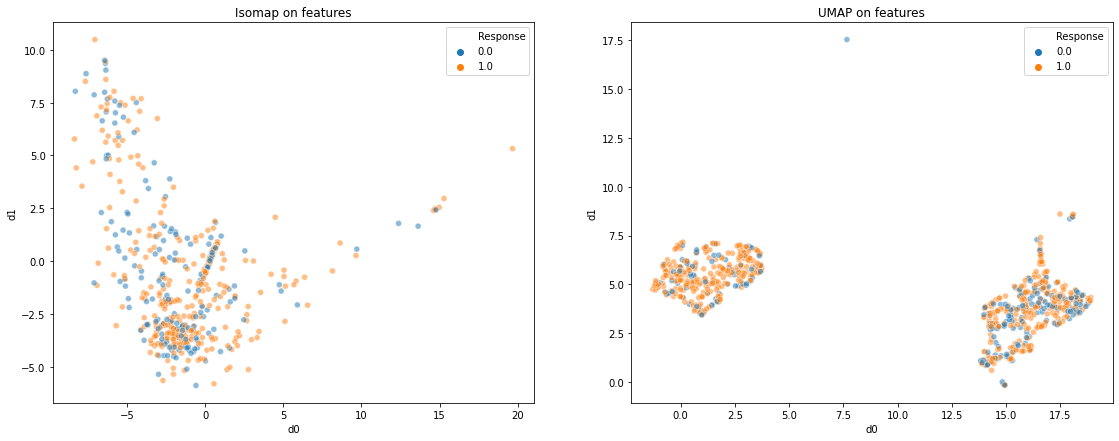

In [155]:
fig, ax = plt.subplots(ncols=2, figsize=(19,7))

cat = 'Response' # Gender
sns.scatterplot(data=embed_iso_momic, x='d0', y='d1', hue=cat, ax=ax[0], alpha=0.5)
sns.scatterplot(data=embed_umap_momic, x='d0', y='d1', hue=cat, ax=ax[1], alpha=0.5)

ax[0].set_title('Isomap on features')
ax[1].set_title('UMAP on features')

## Sparse CCA

In [7]:
## concensus clustering, correspondence analysis, sparse supervised CCA, supervised PCA,
## Co-inertia analysis, MOFA, SNF, Concensus PCA, joint NMF

## https://www.sciencedirect.com/science/article/abs/pii/S0031320310005819

# Differential analysis for overall stage

## RNA

In [38]:
# Stage, time_to_death, time_to_survival, time_to_relapse

In [13]:
meta['time_to_death'] = np.nan
meta.loc[meta['Overall Survival Status']==1, 'time_to_death'] = meta['Time To Overall Survival (Days)']

meta['time_to_relapse'] = np.nan
meta.loc[meta['Relapse Status']==1, 'time_to_relapse'] = meta['Time To Relapse From Diagnosis (Days)']

meta['time_to_survival'] = np.nan
meta.loc[meta['Overall Survival Status']==0, 'time_to_survival'] = meta['Time To Overall Survival (Days)']

In [40]:
target = 'Stage'
X = ds['RNAex'].join(meta[[target]], how='inner')

In [41]:
X.dropna(subset=[target], inplace=True)
Y = X[[target]]
X.drop([target], axis=1, inplace=True)

In [59]:
lincorr_dict = dict()
print("Spearman correlations")
lincorr_dict['spearman']= omic_helpers.spearman_scores(X,Y[target], return_df=True, correction='bonferroni')
print("Pearson correlations")
lincorr_dict['pearson']= omic_helpers.pearson_scores(X,Y[target], return_df=True, correction='bonferroni')
if include_alt_corrs:
    print("Monotonic aligned")
    lincorr_dict['monotonic_aligned'] = omic_helpers.monotonic_alignment(X,Y[[target]], return_df=True)
    print("Distance correlation")
    lincorr_dict['distance_correlation'] = omic_helpers.distcorr(X, Y[[target]], per_column=True,
                                                             return_df=True, columns=['distance_correlation'])
#lincorr_dict['mine'] = omic_helpers.mic_scores(X, Y[target], return_df=True)
lincorr = pd.concat(list(lincorr_dict.values()), axis=1)
lincorr.sort_values(by='spearman_pval', ascending=False, inplace=True)

Spearman correlations


/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



Pearson correlations


/media/bramiozo/home/bramiozo/VIRTUALENVS/multi_omics/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [61]:
lincorr.dropna(inplace=True)
scores = lincorr.join(rnamap, how='inner')

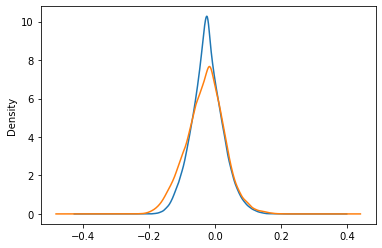

In [62]:
#scores.distance_correlation.plot.kde()
scores.pearson_score.plot.kde()
scores.spearman_score.plot.kde()

In [ ]:
# Interesting negative correlates
# AMY2B
# CBX7
# DAPK2
# GHRL
# LINC00852
# TTC21A
# FAM117A

## Methylation expression diff analysis for continuous Targets